<a href="https://www.kaggle.com/code/yoontaeklee/spacex-falcon-9-firsts-stage-landing-prediction?scriptVersionId=96091331" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spacex/Spacex.csv


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

# Process
1. 데이터셋 확인(null data 확인)
2. EDA(Exploratory Data Analysis)
3. Feature Engineering(one-hot encoding, class 나누기, 구간으로 나누기 등)
4. Model 만들기

# 1. 데이터셋 확인(null data 확인)

In [3]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


In [4]:
df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6104.959412,1.788889,3.500000,1.655556,-86.366477,29.449963
std,26.124701,4694.671720,1.213172,1.595288,1.710254,14.149518,2.141306
min,1.000000,350.000000,1.000000,1.000000,0.000000,-120.610829,28.561857
25%,23.250000,2510.750000,1.000000,2.000000,0.000000,-80.603956,28.561857
50%,45.500000,4701.500000,1.000000,4.000000,1.000000,-80.577366,28.561857
75%,67.750000,8912.750000,2.000000,5.000000,3.000000,-80.577366,28.608058
max,90.000000,15600.000000,6.000000,5.000000,5.000000,-80.577366,34.632093


**1.1 Null data 확인**

In [5]:
for column in df.columns:
    msg = 'column: {:>10}\t Percent of NaN Value: {:.2f}%'.format(column, 100 * (df[column].isnull().sum()) / df[column].shape[0])
    print(msg)

df.isnull().sum()/df.count()*100

column: FlightNumber	 Percent of NaN Value: 0.00%
column:       Date	 Percent of NaN Value: 0.00%
column: BoosterVersion	 Percent of NaN Value: 0.00%
column: PayloadMass	 Percent of NaN Value: 0.00%
column:      Orbit	 Percent of NaN Value: 0.00%
column: LaunchSite	 Percent of NaN Value: 0.00%
column:    Outcome	 Percent of NaN Value: 0.00%
column:    Flights	 Percent of NaN Value: 0.00%
column:   GridFins	 Percent of NaN Value: 0.00%
column:     Reused	 Percent of NaN Value: 0.00%
column:       Legs	 Percent of NaN Value: 0.00%
column: LandingPad	 Percent of NaN Value: 28.89%
column:      Block	 Percent of NaN Value: 0.00%
column: ReusedCount	 Percent of NaN Value: 0.00%
column:     Serial	 Percent of NaN Value: 0.00%
column:  Longitude	 Percent of NaN Value: 0.00%
column:   Latitude	 Percent of NaN Value: 0.00%


FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

- missingno 라이브러리 통해 더 쉽게 null data 확인

<AxesSubplot:>

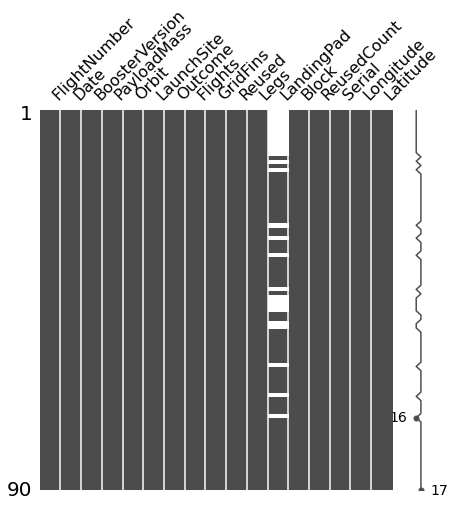

In [6]:
msno.matrix(df=df.iloc[:,:],figsize=(7,7),color=(0.3,0.3,0.3))

<AxesSubplot:>

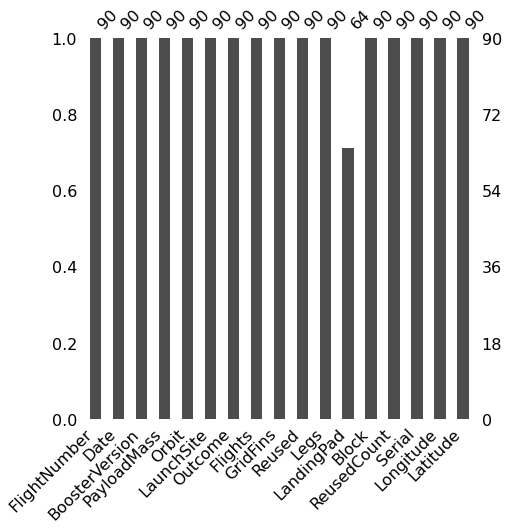

In [7]:
msno.bar(df=df.iloc[:,:],figsize=(7,7),color=(0.3,0.3,0.3))

**1.2 Target label 확인**
- Outcome 의미
    - True Ocean : 특정 바다에 성공적으로 착륙
    - False Ocean : 특정 바다에 착륙 실패
    - True RTLS : 특정 Ground Pad에 성공적으로 착륙
    - False RTLS : 특정 Ground Pad에 착륙 실패
    - True ASDS : 드론쉽에 성공적으로 착륙
    - False ASDS : 드론쉽에 착륙 실패
    - None ASDS, None None : 착륙 실패

In [8]:
landing_outcomes = df.Outcome.value_counts()
print(landing_outcomes)

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64


In [9]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [10]:
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

- Outcome을 성공과 실패로만 나누어 작업

In [11]:
landing_class=[]
for outcome in (df['Outcome']):
    if outcome in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

In [12]:
df['Class'] = landing_class
df[['Class']].head(10)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1
8,0
9,0


# 2. EDA

**2.1 FlightNumber vs Payload**

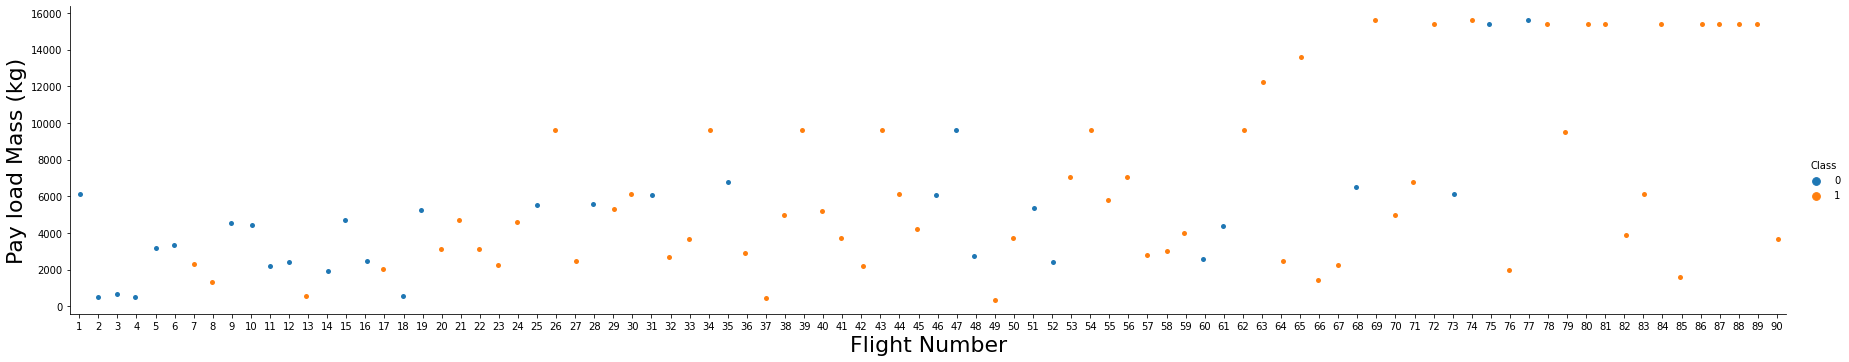

In [13]:
sns.catplot(y="PayloadMass",x="FlightNumber",hue="Class",data=df,aspect=5)
plt.xlabel("Flight Number",fontsize=22)
plt.ylabel("Pay load Mass (kg)",fontsize=22)
plt.show()

**2.2 FlightNumber vs LaunchSite**

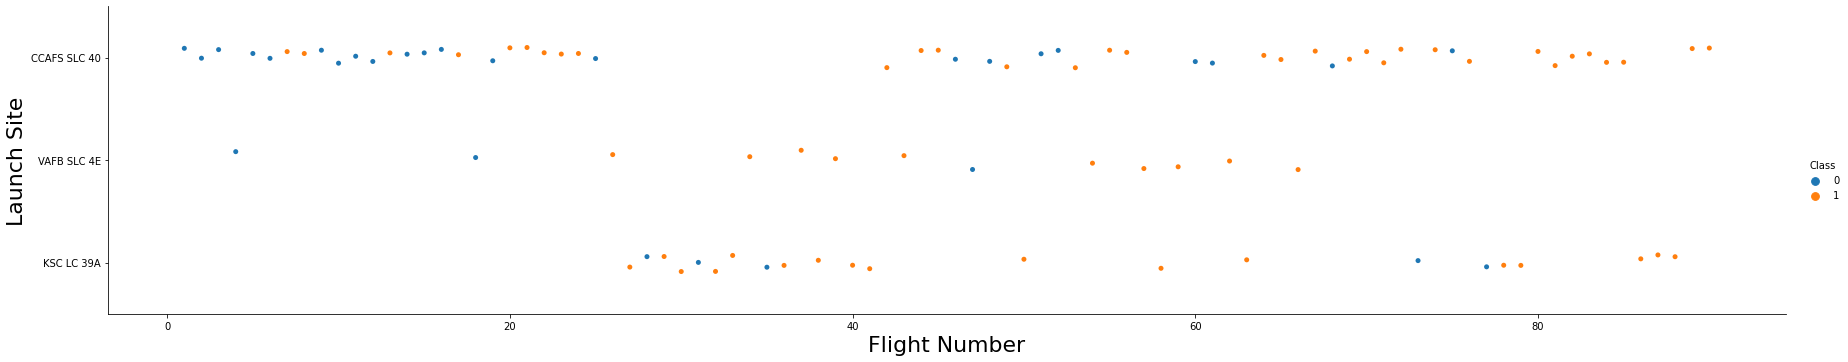

In [14]:
sns.catplot(y="LaunchSite",x="FlightNumber",hue="Class",data=df,aspect=5)
plt.xlabel("Flight Number",fontsize=22)
plt.ylabel("Launch Site",fontsize=22)
plt.show()

**2.3 Payload vs LaunchSite**

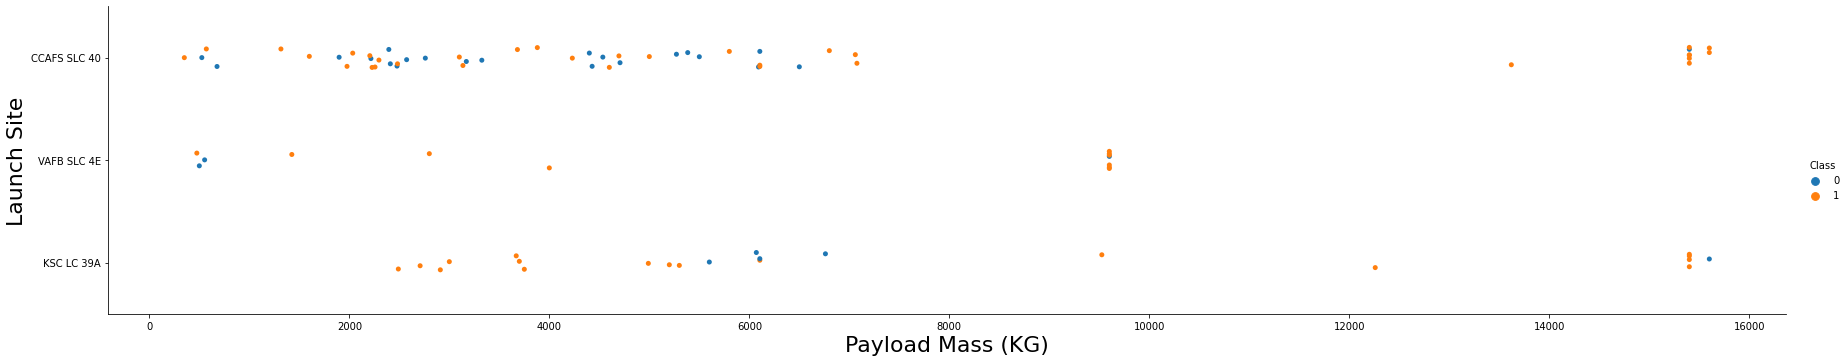

In [15]:
sns.catplot(y="LaunchSite",x="PayloadMass",hue="Class",data=df,aspect=5)
plt.xlabel("Payload Mass (KG)",fontsize=22)
plt.ylabel("Launch Site",fontsize=22)
plt.show()

- 탑재량이 많은 경우 CCAFS SLC 40 혹은 KSC LC 39A 에서 발사함
- CCAFS SLC 40에서 발사하는 로켓 중, 8000Kg 미만을 탑재하는 경우 더 높은 실패율을 보인다

**2.4 Orbit에 따른 성공률**

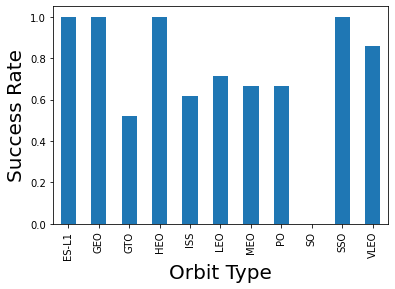

In [16]:
df.groupby("Orbit").mean()["Class"].plot(kind='bar')
plt.xlabel("Orbit Type",fontsize=20)
plt.ylabel("Success Rate",fontsize=20)
plt.show()

**2.5 FlightNumber vs Orbit Type**

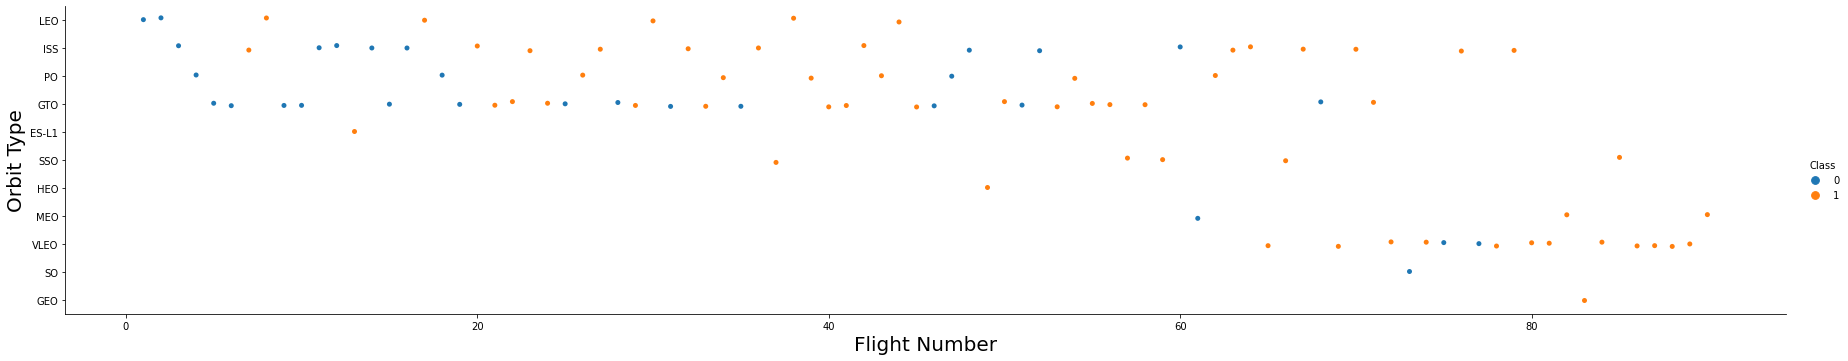

In [17]:
sns.catplot(y="Orbit",x="FlightNumber",hue="Class",aspect=5,data=df)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit Type",fontsize=20)
plt.show()

- LEO의 경우 횟수와 성공이 비례
- GTO의 경우 횟수와 성공이 무관

**2.6 Orbit Type vs Payload**

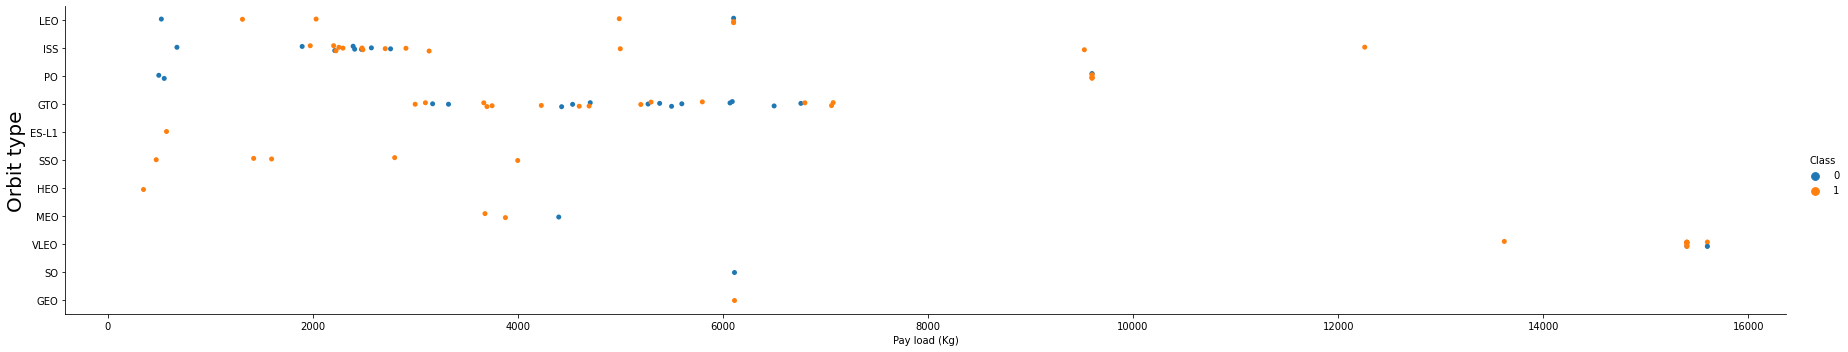

In [18]:
sns.catplot(y="Orbit",x="PayloadMass",hue="Class",data=df,aspect=5)
plt.ylabel("Orbit type",fontsize=20)
plt.xlabel("Pay load (Kg)")
plt.show()

- GTO 궤도의 경우, 적재량이 많을수록 성공률이 떨어짐

**2.7 년도와 성공률과의 관계**

- 현재 갖고있는 날짜 데이터에서 년도에 해당하는 부분만 추출

In [19]:
years = []
def Extract_year(date):
    for i in df["Date"]:
        years.append(i.split("-")[0])
    return years

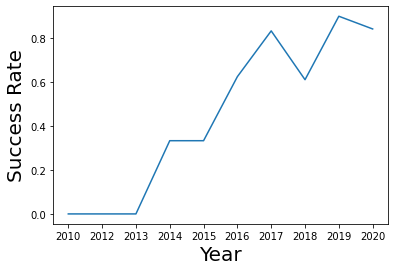

In [20]:
df1 = pd.DataFrame(Extract_year(df['Date']), columns = ['year'])
df1['Class'] = df['Class']
sns.lineplot(x = np.unique(Extract_year(df['Date'])), y = df1.groupby('year')['Class'].mean())
plt.xlabel("Year", fontsize = 20)
plt.ylabel("Success Rate", fontsize = 20)
plt.show()

# 3. Feature Engineering
- 각 feature가 성공률에 얼마나 큰 영향을 끼치는지 확인하고, 후에 모델에 사용

In [21]:
features = df[['FlightNumber','PayloadMass','Orbit','LaunchSite','Flights','GridFins','Reused','Legs','LandingPad','Block','ReusedCount','Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


**3.1 One hot encoding**

In [22]:
features_one_hot = pd.get_dummies(features, columns = ['Orbit','LaunchSite','LandingPad','Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6104.959412,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,525.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,677.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,500.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3170.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
features_one_hot.astype('float64')

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86,87.0,15400.000000,3.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87,88.0,15400.000000,6.0,1.0,1.0,1.0,5.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88,89.0,15400.000000,3.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# **4. Building machine learning model and prediction using the trained model**

- 기존 df에 있는 Class feature에서 새로운 numpy array를 만든다

In [24]:
Y = df['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [25]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(features_one_hot)

- train_test_split 이용하여 트레이닝 데이터와 테스트 데이터 나누기

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=2)
print('Train set: ',X_train.shape, Y_train.shape)
print('Test set: ',X_test.shape, Y_test.shape)

Train set:  (72, 80) (72,)
Test set:  (18, 80) (18,)


- GridSearchCV 구현

In [27]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}
lr=LogisticRegression()


In [28]:
logreg_cv = GridSearchCV(lr,parameters,cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [29]:
print("best parameters :  ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

best parameters :   {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


In [30]:
print('test set accuracy : ',logreg_cv.score(X_test, Y_test))

test set accuracy :  0.8333333333333334


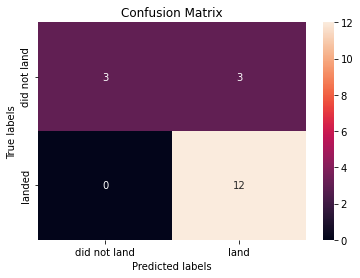

In [31]:
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

- 착륙할 것이라고 예측했으나 실제로는 그러지 못한 케이스 3건.

- 서포트 벡터 머신을 만들기 위해 새롭게 파라미터를 정의하여 같은 방식으로 돌린다

In [32]:
parameters = {'kernel':('linear','rbf','poly','rbf','sigmoid'),'C':np.logspace(-3,3,5),'gamma':np.logspace(-3,3,5)}
svm = SVC()

In [33]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [34]:
print("best parameters : ",svm_cv.best_params_)
print("accuracy : ",svm_cv.best_score_)
print("test set accuracy : ",svm_cv.score(X_test, Y_test))

best parameters :  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy :  0.8482142857142858
test set accuracy :  0.8333333333333334


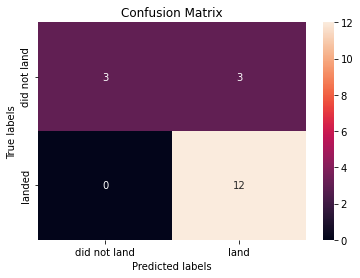

In [35]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

- 결정 트리 classifier를 사용하여 테스트

In [36]:
parameters = {'criterion': ['gini','entropy'],
             'splitter':['best','random'],
             'max_depth':[2 * n for n in range(1,10)],
             'max_features':['auto','sqrt'],
             'min_samples_leaf':[1,2,4],
             'min_samples_split':[2,5,10]}
tree = DecisionTreeClassifier()

In [37]:
tree_cv = GridSearchCV(tree, parameters, cv = 10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [38]:
print("best parameters : ",tree_cv.best_params_)
print("accuracy : ",tree_cv.best_score_)
print("test set accuracy : ",tree_cv.score(X_test,Y_test))

best parameters :  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
accuracy :  0.8607142857142858
test set accuracy :  0.6666666666666666


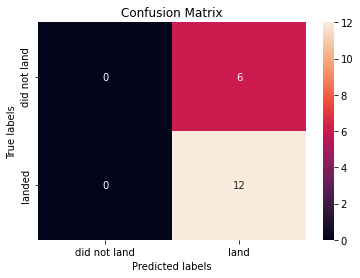

In [39]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

- KNN 모델

In [40]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [41]:
knn_cv = GridSearchCV(KNN,parameters,cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [42]:
print("best parameters : ",knn_cv.best_params_)
print("accuracy : ",knn_cv.best_score_)
print("test set accuracy : ",knn_cv.score(X_test,Y_test))

best parameters :  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
accuracy :  0.8339285714285714
test set accuracy :  0.8333333333333334


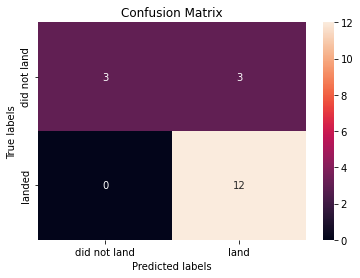

In [43]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

- 위의 모든 방법들로 테스트 한 결과, Decision Tree Classification의 방법이 가장 높은 정확도를 보였다